# IEEE Publication 3.0.1
* Most of the code is moved to the corresponding folders (encouraging github repo)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms, models
from torch.autograd import Variable

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from sklearn.model_selection import train_test_split

from PIL import Image
import numpy as np
import random
import os
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import math
import copy

from character_mappings import *

from collections import defaultdict

%load_ext autoreload
%autoreload 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# Hyperparameters
* MODELS_FOLDER
  *  Pre trained models folder
* RESULTS_AND_HISTORY_FOLDER
  * History and results dicts save folder
* CL
  * Curriculum learning stuff 
* ALPHA
  * Balance between vqa and seg loss (should be between 0,1)
  * Higher -> more vqa, less seg
* ADJUST_ALPHA
  * Dynamically adjust ALPHA using DATAP
* EPSILON
  * Learning rate for ALPHA adjustment (see UPDATING ALPHA in training())
* ADJUST_WEIGHTS
  * Dynamically adjust class weights using DAWEP
* ADJUST_WEIGHTS_LR
  * Learning rate for weight adjustment

In [2]:
hyperparameters = {
    'SEED': 99999, # for reproducibility
    'MODELS_FOLDER': 'saved_models/',
    'RESULTS_AND_HISTORY_FOLDER': 'results_and_history/',
    'DATASET': {}, # Filled in a few cells below
    'SAVE_MODEL': False, # Save model at the end of the training
    'BATCH_SIZE': 8,
    'EPOCHS': 25,
    'SHUFFLE': False,
    'PIN_MEMORY': True,
    'NUM_WORKERS': 16,
    'LEARNING_RATE': 1e-3,
    'MOMENTUM': 0.9, # For SGD optimizer
    'LR_SCHEDULING': {
        'TYPE': 'StepLR',
        'STEP_SIZE': 3,
        'GAMMA': 0.95,
    },
    'CL': { 
        'ADJUST_ALPHA': True,
        'ALPHA': 0.5,
        'EPSILON': 0.002, 
        'ADJUST_WEIGHTS': True,
        'ADJUST_WEIGHTS_LR': 0.001
    },
    'IMAGE': {
        'RES': 200,
        'RES_UNET_SIZES': {
            128: (64, 32, 16),
            200: (100, 50, 25)
        },
        'IN_CHANNELS': 3,
        'FEATURES': 64,
        'UNET_FEATURES_DIM': (64, 128, 256), # Used by VQAClassifier to pool the incoming features
        'RELU_INPLACE': True,
    },
    'TEXT': {
        'N_CHAR_TOKENS': len(char2idx.keys()), # char2idx is from character_mappings.py
        'EMB_DIM': 8,
        'POS_EMB_DROPOUT': 0.0,
        'FREEZE_UNET': False,
        'TEXT_DROPOUT_PROB': 0.2, # VQAClassifier text features dropout rate # 0.2
        'COMBINED_DROPOUT_PROB': 0.2, # VQAClassifier combined features dropout rate # 0.2
    },
}

### Add Segmentation Class Names

In [3]:
# https://arxiv.org/pdf/2012.02951.pdf
SEG_CLASS_NAMES = [
    'Background',
    'Building-flooded',
    'Building-non-flodded',
    'Road-flooded',
    'Road-non-flooded',
    'Water',
    'Tree',
    'Vehicle',
    'Pool',
    'Grass'
]


hyperparameters['IMAGE']['SEG_CLASS_NAMES'] = SEG_CLASS_NAMES
hyperparameters['IMAGE']['NUM_SEG_CLASSES'] = len(SEG_CLASS_NAMES)

print(f"{hyperparameters['IMAGE']['NUM_SEG_CLASSES']} classes in total for segmentation")

10 classes in total for segmentation


### Make the Save Folders

In [4]:
os.makedirs(hyperparameters['MODELS_FOLDER'], exist_ok=True)
os.makedirs(hyperparameters['RESULTS_AND_HISTORY_FOLDER'], exist_ok=True)

# Seed everything

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(hyperparameters['SEED'])

# Dataset

In [6]:
#from custom_datasets.cached import FloodnetCachedDataset
from custom_datasets.non_cached import FloodnetDataset

# Dataset 
* NOTE: You can set your own data root from below:

In [7]:
hyperparameters['DATASET']['DATA_ROOT'] = '../../data/'
hyperparameters['DATASET']['IMAGES_ROOT'] = os.path.join(hyperparameters['DATASET']['DATA_ROOT'], 'FloodNet/track2_vqa/Images/')
hyperparameters['DATASET']['QUESTIONS_ROOT'] = os.path.join(hyperparameters['DATASET']['DATA_ROOT'], 'FloodNet/track2_vqa/Questions/')

In [8]:
hyperparameters['DATASET']['TRAIN_IMAGES_PATH'] = os.path.join(hyperparameters['DATASET']['IMAGES_ROOT'], 'Train_Image')

# BELOW IS NOT REQUIRED SINCE WE DIVIDE THE TRAIN ITSELF
#valid_images_path = os.path.join(hyperparameters['DATASET']['IMAGES_ROOT'], 'Valid_Image')
#test_images_path = os.path.join(hyperparameters['DATASET']['IMAGES_ROOT'], 'Test_Image')

# From segmentation track
hyperparameters['DATASET']['MASK_IMAGES_PATH'] = os.path.join(hyperparameters['DATASET']['DATA_ROOT'], 'FloodNet/track1_seg/train-label-img')

hyperparameters['DATASET']['TRAIN_QUESTIONS_PATH'] = os.path.join(hyperparameters['DATASET']['QUESTIONS_ROOT'], 'Training Question.json')
hyperparameters['DATASET']['VALID_QUESTIONS_PATH'] = os.path.join(hyperparameters['DATASET']['QUESTIONS_ROOT'], 'Valid Question.json')
hyperparameters['DATASET']['TEST_QUESTIONS_PATH'] = os.path.join(hyperparameters['DATASET']['QUESTIONS_ROOT'], 'Test_Question.json')

In [9]:
with open(hyperparameters['DATASET']['TRAIN_QUESTIONS_PATH'], 'r') as f:
    train_questions = json.load(f)
    
train_ds_len = len(train_questions)
train_ds_len

4511

In [10]:
with open(hyperparameters['DATASET']['VALID_QUESTIONS_PATH'], 'r') as f:
    valid_questions = json.load(f)
    
valid_ds_len = len(valid_questions)
valid_ds_len

1415

In [11]:
with open(hyperparameters['DATASET']['TEST_QUESTIONS_PATH'], 'r') as f:
    test_questions = json.load(f)
    
test_ds_len = len(test_questions)
test_ds_len

1429

In [12]:
train_questions['0']

{'Image_ID': '10165.JPG',
 'Question': 'What is the overall condition of the given image?',
 'Ground_Truth': 'flooded',
 'Question_Type': 'Condition_Recognition'}

# NOTE: VALID AND TEST SETS DON'T HAVE GROUND TRUTH

In [13]:
valid_questions['0']

{'Image_ID': '10169.JPG',
 'Question': 'What is the overall condition of the given image?',
 'Question_Type': 'Condition_Recognition'}

In [14]:
test_questions['0']

{'Image_ID': '10163.JPG',
 'Question': 'What is the overall condition of the given image?',
 'Question_Type': 'Condition_Recognition'}

In [15]:
for k,v in valid_questions.items():
    if 'Ground_Truth' in v.keys():
        print(f'Found at: {k}')

In [16]:
question_type_counter_train = defaultdict(int)
question_type_counter_valid = defaultdict(int)
question_type_counter_test = defaultdict(int)

keys_train = set()
keys_valid = set()
keys_test = set()

for k, v in train_questions.items():
    q_type = v['Question_Type']
    question_type_counter_train[q_type] += 1
    
    for __key in v.keys():
        keys_train.add(__key)

for k, v in valid_questions.items():
    q_type = v['Question_Type']
    question_type_counter_valid[q_type] += 1
    
    for __key in v.keys():
        keys_valid.add(__key)
        
for k, v in test_questions.items():
    q_type = v['Question_Type']
    question_type_counter_test[q_type] += 1
    
    for __key in v.keys():
        keys_test.add(__key)

In [17]:
print(question_type_counter_train)
print(question_type_counter_valid)
print(question_type_counter_test)

print(keys_train)
print(keys_valid)
print(keys_test)

defaultdict(<class 'int'>, {'Condition_Recognition': 2315, 'Complex_Counting': 693, 'Simple_Counting': 636, 'Yes_No': 867})
defaultdict(<class 'int'>, {'Condition_Recognition': 726, 'Simple_Counting': 197, 'Yes_No': 276, 'Complex_Counting': 216})
defaultdict(<class 'int'>, {'Condition_Recognition': 728, 'Yes_No': 278, 'Complex_Counting': 222, 'Simple_Counting': 201})
{'Question_Type', 'Question', 'Ground_Truth', 'Image_ID'}
{'Question_Type', 'Question', 'Image_ID'}
{'Question_Type', 'Question', 'Image_ID'}


In [18]:
possible_answers = defaultdict(int)

for k, v in train_questions.items():
    q_answer = v['Ground_Truth']
    possible_answers[q_answer] += 1
    
hyperparameters['DATASET']['NUM_VQA_ANSWER_CLASSES'] = len(possible_answers.keys())
hyperparameters['DATASET']['NUM_VQA_ANSWER_CLASSES'] 

41

# Lookup tables for possible types

In [19]:
# All possible questions types mapped to an integer
#question_type_dict = {k:i for i, k in enumerate(question_type_counter_train.keys())}
hyperparameters['DATASET']['QUESTION_TYPE_DICT'] = {k:i for i, k in enumerate(question_type_counter_train.keys())}
# All possible answers mapped to an integer
#answers_dict =  {k:i for i, k in enumerate(possible_answers.keys())}
hyperparameters['DATASET']['ANSWERS_DICT'] = {k:i for i, k in enumerate(possible_answers.keys())}

In [20]:
#hyperparameters['DATASET']['ANSWERS_DICT']

# NOTE: IS IT A GOOD IDEA TO SPLIT TRAIN 
## USE CL TO MAKE SPLITS (MUSTAFA HOCA)

In [21]:
questions_list = list(train_questions.values())
questions_list[:2]

[{'Image_ID': '10165.JPG',
  'Question': 'What is the overall condition of the given image?',
  'Ground_Truth': 'flooded',
  'Question_Type': 'Condition_Recognition'},
 {'Image_ID': '10166.JPG',
  'Question': 'What is the overall condition of the given image?',
  'Ground_Truth': 'flooded',
  'Question_Type': 'Condition_Recognition'}]

In [22]:
hyperparameters['DATASET'].keys()

dict_keys(['DATA_ROOT', 'IMAGES_ROOT', 'QUESTIONS_ROOT', 'TRAIN_IMAGES_PATH', 'MASK_IMAGES_PATH', 'TRAIN_QUESTIONS_PATH', 'VALID_QUESTIONS_PATH', 'TEST_QUESTIONS_PATH', 'NUM_VQA_ANSWER_CLASSES', 'QUESTION_TYPE_DICT', 'ANSWERS_DICT'])

In [23]:
"""
full_train_dataset = FloodnetCachedDataset(
    #full_cache_file=os.path.join(CACHE_FOLDER, f'FloodNet_vqa_seg_combined_train_{RES}_no_pad.npy'),
    #full_cache_file=os.path.join(CACHE_FOLDER, f'FloodNet_vqa_seg_combined_train_{RES}.npy'),
    full_cache_file=os.path.join(CACHE_FOLDER, f'FloodNet_vqa_seg_combined_train_{RES}_optimized.npy'),
    char2idx=char2idx,
    idx2char=idx2char,
    max_question_len=MAX_QUESTION_LEN
)
"""

img_transforms = A.Compose([
    A.Resize(width=hyperparameters['IMAGE']['RES'], height=hyperparameters['IMAGE']['RES']),

])


full_train_dataset = FloodnetDataset(
    train_images_path=hyperparameters['DATASET']['TRAIN_IMAGES_PATH'],
    mask_images_path=hyperparameters['DATASET']['MASK_IMAGES_PATH'],
    img_transforms=img_transforms,
    num_segmentation_classes=hyperparameters['IMAGE']['NUM_SEG_CLASSES'],
    questions_list=questions_list,
    answers_dict=hyperparameters['DATASET']['ANSWERS_DICT'],
    char2idx=char2idx, # from character_mappings.py
    idx2char=idx2char, # from character_mappings.py
    question_type_dict=hyperparameters['DATASET']['QUESTION_TYPE_DICT'], 
    max_question_len='auto',
    use_average_len=False,
)


ds_sample = full_train_dataset[0]

Average question length: 51
Maximum question length: 70


### Save Maximum Question Length

In [24]:
hyperparameters['DATASET']['MAX_QUESTION_LEN'] = full_train_dataset.max_question_len

In [25]:
print(ds_sample[0].shape)
print(ds_sample[1].shape)
print(ds_sample[2].shape)
print(ds_sample[3].shape)
print(ds_sample[4])
print(ds_sample[5])

torch.Size([3, 200, 200])
torch.Size([10, 200, 200])
torch.Size([70])
torch.Size([70])
0
0


### Cached version is no longer in use due to the memory issues

### Get all answers before

In [26]:
y_full = []

for i in tqdm(range(len(full_train_dataset))):
    # This is time consuming
    #y_full.append(full_train_dataset[i][-1])
    y_full.append(full_train_dataset.get_only_answers(i))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4511/4511 [00:00<00:00, 2889950.41it/s]


In [27]:
full_indexes = list(range(len(y_full)))

In [28]:
len(full_indexes)

4511

In [29]:
train_dataset_idx, test_dataset_idx, y_train, y_test = train_test_split(full_indexes, y_full, test_size=0.30, random_state=hyperparameters['SEED'])
test_dataset_idx, val_dataset_idx, y_test, y_val = train_test_split(test_dataset_idx, y_test, test_size=0.50, random_state=hyperparameters['SEED'])

### Save original IDX 

In [30]:
hyperparameters['DATASET']['TRAIN_DATASET_IDX'] = train_dataset_idx
hyperparameters['DATASET']['VAL_DATASET_IDX'] = val_dataset_idx
hyperparameters['DATASET']['TEST_DATASET_IDX'] = test_dataset_idx

In [31]:
train_questions_list = [questions_list[i] for i in train_dataset_idx] 
val_questions_list = [questions_list[i] for i in val_dataset_idx] 
test_questions_list = [questions_list[i] for i in test_dataset_idx] 

In [32]:
train_dataset = FloodnetDataset(
    train_images_path=hyperparameters['DATASET']['TRAIN_IMAGES_PATH'],
    mask_images_path=hyperparameters['DATASET']['MASK_IMAGES_PATH'],
    img_transforms=img_transforms,
    num_segmentation_classes=hyperparameters['IMAGE']['NUM_SEG_CLASSES'],
    questions_list=train_questions_list,
    answers_dict=hyperparameters['DATASET']['ANSWERS_DICT'],
    char2idx=char2idx, # from character_mappings.py
    idx2char=idx2char, # from character_mappings.py
    question_type_dict=hyperparameters['DATASET']['QUESTION_TYPE_DICT'], 
    max_question_len=hyperparameters['DATASET']['MAX_QUESTION_LEN'],
    use_average_len=False,
)

val_dataset = FloodnetDataset(
    train_images_path=hyperparameters['DATASET']['TRAIN_IMAGES_PATH'],
    mask_images_path=hyperparameters['DATASET']['MASK_IMAGES_PATH'],
    img_transforms=img_transforms,
    num_segmentation_classes=hyperparameters['IMAGE']['NUM_SEG_CLASSES'],
    questions_list=val_questions_list,
    answers_dict=hyperparameters['DATASET']['ANSWERS_DICT'],
    char2idx=char2idx, # from character_mappings.py
    idx2char=idx2char, # from character_mappings.py
    question_type_dict=hyperparameters['DATASET']['QUESTION_TYPE_DICT'], 
    max_question_len=hyperparameters['DATASET']['MAX_QUESTION_LEN'],
    use_average_len=False,
)


test_dataset = FloodnetDataset(
    train_images_path=hyperparameters['DATASET']['TRAIN_IMAGES_PATH'],
    mask_images_path=hyperparameters['DATASET']['MASK_IMAGES_PATH'],
    img_transforms=img_transforms,
    num_segmentation_classes=hyperparameters['IMAGE']['NUM_SEG_CLASSES'],
    questions_list=test_questions_list,
    answers_dict=hyperparameters['DATASET']['ANSWERS_DICT'],
    char2idx=char2idx, # from character_mappings.py
    idx2char=idx2char, # from character_mappings.py
    question_type_dict=hyperparameters['DATASET']['QUESTION_TYPE_DICT'], 
    max_question_len=hyperparameters['DATASET']['MAX_QUESTION_LEN'],
    use_average_len=False,
)

# Dynamic Weights

In [33]:
# Initialize each class weight to be 1
dynamic_weights = {w: 1.0 for w in range(hyperparameters['DATASET']['NUM_VQA_ANSWER_CLASSES'])}

# Dataloader

In [34]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=hyperparameters['BATCH_SIZE'],
    shuffle=hyperparameters['SHUFFLE'],
    num_workers=hyperparameters['NUM_WORKERS'],
    pin_memory=hyperparameters['PIN_MEMORY'],
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=hyperparameters['BATCH_SIZE'],
    shuffle=hyperparameters['SHUFFLE'],
    num_workers=hyperparameters['NUM_WORKERS'],
    pin_memory=hyperparameters['PIN_MEMORY'],
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=hyperparameters['BATCH_SIZE'],
    shuffle=hyperparameters['SHUFFLE'],
    num_workers=hyperparameters['NUM_WORKERS'],
    pin_memory=hyperparameters['PIN_MEMORY'],
)

In [35]:
print(f'Number of batches, train: {len(train_dataloader)}, val: {len(val_dataloader)}, test: {len(test_dataloader)}')

Number of batches, train: 395, val: 85, test: 85


In [36]:
#sample_batch = next(iter(train_dataloader))

# Model

In [37]:
from models.segmentation import UNet
from models.vqa import VQAClassifier

In [38]:
unet = UNet(
    in_channels=hyperparameters['IMAGE']['IN_CHANNELS'], 
    n_classes=hyperparameters['IMAGE']['NUM_SEG_CLASSES'], 
    features=hyperparameters['IMAGE']['FEATURES'], 
    relu_inplace=hyperparameters['IMAGE']['RELU_INPLACE']
)

In [39]:
hyperparameters['TEXT']

{'N_CHAR_TOKENS': 42,
 'EMB_DIM': 8,
 'POS_EMB_DROPOUT': 0.0,
 'FREEZE_UNET': False,
 'TEXT_DROPOUT_PROB': 0.2,
 'COMBINED_DROPOUT_PROB': 0.2}

In [40]:
model = VQAClassifier(
    n_char_tokens=hyperparameters['TEXT']['N_CHAR_TOKENS'], 
    emb_dim=hyperparameters['TEXT']['EMB_DIM'], 
    pos_emb_dropout=hyperparameters['TEXT']['POS_EMB_DROPOUT'], 
    max_question_len=hyperparameters['DATASET']['MAX_QUESTION_LEN'], 
    n_vqa_answer_classes=hyperparameters['DATASET']['NUM_VQA_ANSWER_CLASSES'],
    unet=unet,
    unet_features_dim=hyperparameters['IMAGE']['UNET_FEATURES_DIM'],
    image_features_pool_dim=hyperparameters['IMAGE']['RES_UNET_SIZES'][hyperparameters['IMAGE']['RES']],
    freeze_unet=hyperparameters['TEXT']['FREEZE_UNET'],
    text_dropout_prob=hyperparameters['TEXT']['TEXT_DROPOUT_PROB'],
    combined_dropout_prob=hyperparameters['TEXT']['COMBINED_DROPOUT_PROB'],
)

Total (image+text) features: 703


/home/shodan/Documents/deep_learning/pytorch/thesis/PUBLICATIONS/publication_1_v2/models/vqa.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pe_tensor = torch.tensor(


### Total Parameters

In [41]:
from utils.model_utils import print_total_parameters

In [42]:
print_total_parameters(model)

Total: 9,456,274, trainable: 9,456,274


# Optimizer, Loss and Scheduler

In [43]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=hyperparameters['LEARNING_RATE'], 
)

"""
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=LEARNING_RATE, 
)
"""

criterion_seg = nn.BCEWithLogitsLoss(reduction='mean')
criterion_answer = nn.CrossEntropyLoss()

#scaler = torch.cuda.amp.GradScaler()

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=hyperparameters['LR_SCHEDULING']['STEP_SIZE'],
    gamma=hyperparameters['LR_SCHEDULING']['GAMMA'],
    verbose=True,
)

Adjusting learning rate of group 0 to 1.0000e-03.


# Test Dynamic Weights

In [44]:
import learning.dynamic_weights as dw

In [45]:
#  image, masks, question_tokens, pad_mask, question_type_ids, answer_ids
_sample = next(iter(train_dataloader))

In [46]:
__preds, __attn_scores, __final_output = model(_sample[0], _sample[2], _sample[3])

__preds.shape

torch.Size([8, 41])

In [47]:
_ = dw.loss_per_class(
    pred=__preds.detach(), # IF detach() is not used, backward function will remain
    batch_size=__preds.shape[0], 
    target=_sample[5], 
    weight=dynamic_weights
)

Loss: 0.4823 for target: 0
Loss: 1.4112 for target: 1
Loss: 0.4474 for target: 2
Loss: 0.4893 for target: 8
Loss: 0.8655 for target: 9


In [48]:
dw.grad_wrt_weight(
    pred=__preds.detach(), 
    target_wrt=2, 
    target=_sample[5], 
    batch_size=__preds.shape[0], 
    weight=dynamic_weights
)

tensor(-0.0145)

In [49]:
loss_my = dw.CELoss(
    pred=__preds.detach(), 
    batch_size=__preds.shape[0], 
    target=_sample[5], 
    weight=dynamic_weights, 
    reduction='mean'
)


loss_torch = F.cross_entropy(
    __preds.detach(), 
    _sample[5], 
    weight=torch.tensor(list(dynamic_weights.values())),
)

print(f'Loss PyTorch: {loss_torch:.4f}, My: {loss_my:.4f}')

Loss PyTorch: 3.6957, My: 3.6957


### Adjust Weights

In [50]:
from learning.curriculum_learning import adjust_weights

# Save Hyperparameters Dict as a JSON File

In [51]:
with open(os.path.join(hyperparameters['RESULTS_AND_HISTORY_FOLDER'], 'hyperparameters.json'), 'w') as f:
    json.dump(hyperparameters, f)

# Training
### Segmentation Metrics

In [52]:
from learning.segmentation_metrics import calculate_segmentation_metrics

In [53]:
from learning.training import train_iter
from learning.training import validate_iter

In [54]:
# Records common metrics per epoch
history = {
    'train_loss': [], # Total loss
    'val_loss': [],
    'train_answer_acc': [],
    'val_answer_acc': [],
    #'train_question_type': [],
    #'test_question_type': [],
    'train_dice_score': [],
    'val_dice_score': [],
    'train_miou': [],
    'val_miou': [],
    'alpha': [],
}


# Records epoch_history per epoch
# ex: inter_epoch_history['train'][0]['dice_score']
inter_epoch_history = {
    'train': [],
    'val': [],
}

# Average past grades curriculum (IMPLEMENT MAYBE LATER ?)
# Here vqa and seg defined in general, any metric can be applied
past_avg_grades = {
    'vqa': [],
    'seg': []
}

## NEW: MODEL CHECKPOINT
__model_save_path_checkpoint = os.path.join(
    hyperparameters['MODELS_FOLDER'], 
    f"VQAClassifier_{hyperparameters['IMAGE']['RES']}_checkpoint.pth"
)

best_acc_epoch = -99

def start_training(__ALPHA, __ADJUST_ALPHA, __EPSILON,  __ADJUST_WEIGHTS, _dynamic_weights, __ADJUST_WEIGHTS_LR, criterion_answer, criterion_seg):

    global best_acc_epoch
    model.to(device)
    
    best_acc = -1.0
    
    criterion_answer, criterion_seg = criterion_answer.to(device), criterion_seg.to(device)
    
    for epoch in range(1, hyperparameters['EPOCHS']+1):
        
        if hyperparameters['CL']['ADJUST_WEIGHTS']:
            print(f'Current value of ALPHA: {__ALPHA:.2f}, EPSILON: {__EPSILON:.5f}, ADJUST_WEIGHTS_LR: {__ADJUST_WEIGHTS_LR:.5f}')
        else:
            print(f'Current value of ALPHA: {__ALPHA:.2f}, EPSILON: {__EPSILON:.5f}')

            
        # Add current alpha value to history
        history['alpha'].append(__ALPHA)    
            
        # Train
        train_metrics = train_iter(
            epoch=epoch, 
            dataloader=train_dataloader, 
            model=model, 
            device=device,
            optimizer=optimizer, 
            answer_loss_fn=criterion_answer, 
            seg_loss_fn=criterion_seg, 
            alpha=__ALPHA,
            adjust_alpha=__ADJUST_ALPHA,
            epsilon=__EPSILON,
            _adjust_weights=__ADJUST_WEIGHTS, # not to be confused with the function
            adjust_weights_fn=adjust_weights,
            dynamic_weights=_dynamic_weights,
            adjust_weights_lr=__ADJUST_WEIGHTS_LR,
        )
    
        inter_epoch_history['train'].append(train_metrics['epoch_history'])
        
        # Validation
        val_metrics = validate_iter(
            epoch=epoch, 
            dataloader=val_dataloader, 
            model=model, 
            device=device, 
            answer_loss_fn=criterion_answer, 
            seg_loss_fn=criterion_seg, 
            alpha=__ALPHA,
            dynamic_weights=_dynamic_weights
        )

        ### OVERWRITE ALPHA
        if hyperparameters['CL']['ADJUST_ALPHA']:
            __ALPHA = train_metrics['alpha']
        ###################
        
        #avg_dice_test, miou_test = calculate_segmentation_metrics(val_dataloader, model)
        #segmentation_metrics_val = calculate_segmentation_metrics(val_dataloader, model)
        inter_epoch_history['val'].append(val_metrics['epoch_history'])

                
        avg_dice_train = train_metrics['avg_dice_score']
        avg_dice_val = val_metrics['avg_dice_score']
        miou_train = train_metrics['miou_score']
        miou_val = val_metrics['miou_score']
        

        # Record metrics
        history['train_loss'].append(train_metrics['avg_total_loss'])
        history['val_loss'].append(val_metrics['avg_total_loss'])
        history['train_answer_acc'].append(train_metrics['avg_answer_acc'])
        history['val_answer_acc'].append(val_metrics['avg_answer_acc'])
        # seg metrics
        history['train_dice_score'].append(avg_dice_train)
        history['val_dice_score'].append(avg_dice_val)
        history['train_miou'].append(miou_train)
        history['val_miou'].append(miou_val)
                
        # Print dice scores
        print(f'Average dice score train: %{avg_dice_train:.2f}, val: %{avg_dice_val:.2f}, mIoU train: %{miou_train:.2f}, val: %{miou_val:.2f}')
        
        # Scheduler steps
        scheduler.step()
        
        if val_metrics['avg_answer_acc'] > best_acc:
            best_acc = val_metrics['avg_answer_acc']
            print(f'New best validation answer acc: %{best_acc:.4f}')
            best_acc_epoch = epoch
            
            torch.save({
                'unet_state_dict': model.image_encoder.state_dict(),
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
            }, __model_save_path_checkpoint)
            print(f'Model checkpoint is saved to: {__model_save_path_checkpoint}')
        

#### Start training

In [55]:
start_training(
    __ALPHA=copy.deepcopy(hyperparameters['CL']['ALPHA']), # keep the original alpha value 
    __ADJUST_ALPHA=hyperparameters['CL']['ADJUST_ALPHA'], 
    __EPSILON=hyperparameters['CL']['EPSILON'],
    __ADJUST_WEIGHTS=hyperparameters['CL']['ADJUST_WEIGHTS'], 
    _dynamic_weights=dynamic_weights, 
    __ADJUST_WEIGHTS_LR=hyperparameters['CL']['ADJUST_WEIGHTS_LR'], 
    criterion_answer=criterion_answer, 
    criterion_seg=criterion_seg
)

Current value of ALPHA: 0.50, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.5000


Epoch: 1, Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:38<00:00,  1.81batch/s, Loss: 0.4652, Acc answer: %61.93]


validate_iter current alpha: 0.5000


Epoch: 1, Val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.84batch/s, Loss: 0.4663, Acc answer: %73.71]


Average dice score train: %66.14, val: %66.41, mIoU train: %49.87, val: %50.11
Adjusting learning rate of group 0 to 1.0000e-03.
New best validation answer acc: %73.7075
Model checkpoint is saved to: saved_models/VQAClassifier_200_checkpoint.pth
Current value of ALPHA: 0.17, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.1720


Epoch: 2, Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:28<00:00,  1.89batch/s, Loss: 0.2417, Acc answer: %71.81]


validate_iter current alpha: 0.1720


Epoch: 2, Val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.82batch/s, Loss: 0.2765, Acc answer: %69.57]


Average dice score train: %65.69, val: %65.45, mIoU train: %49.31, val: %49.00
Adjusting learning rate of group 0 to 1.0000e-03.
Current value of ALPHA: 0.13, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.1277


Epoch: 3, Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:31<00:00,  1.87batch/s, Loss: 0.2123, Acc answer: %73.04]


validate_iter current alpha: 0.1277


Epoch: 3, Val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.81batch/s, Loss: 0.2165, Acc answer: %72.97]


Average dice score train: %69.82, val: %69.82, mIoU train: %54.02, val: %54.04
Adjusting learning rate of group 0 to 9.5000e-04.
Current value of ALPHA: 0.13, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.1285


Epoch: 4, Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:31<00:00,  1.87batch/s, Loss: 0.2098, Acc answer: %73.49]


validate_iter current alpha: 0.1285


Epoch: 4, Val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.82batch/s, Loss: 0.1992, Acc answer: %74.15]


Average dice score train: %72.52, val: %72.56, mIoU train: %57.26, val: %57.30
Adjusting learning rate of group 0 to 9.5000e-04.
New best validation answer acc: %74.1507
Model checkpoint is saved to: saved_models/VQAClassifier_200_checkpoint.pth
Current value of ALPHA: 0.16, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.1555


Epoch: 5, Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:29<00:00,  1.88batch/s, Loss: 0.2195, Acc answer: %74.06]


validate_iter current alpha: 0.1555


Epoch: 5, Val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.82batch/s, Loss: 0.2864, Acc answer: %66.47]


Average dice score train: %61.87, val: %61.27, mIoU train: %45.34, val: %44.68
Adjusting learning rate of group 0 to 9.5000e-04.
Current value of ALPHA: 0.20, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.2046


Epoch: 6, Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:29<00:00,  1.88batch/s, Loss: 0.2414, Acc answer: %75.04]


validate_iter current alpha: 0.2046


Epoch: 6, Val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.81batch/s, Loss: 0.2440, Acc answer: %72.67]


Average dice score train: %73.26, val: %73.09, mIoU train: %58.16, val: %57.94
Adjusting learning rate of group 0 to 9.0250e-04.
Current value of ALPHA: 0.27, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.2688


Epoch: 7, Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:30<00:00,  1.87batch/s, Loss: 0.2684, Acc answer: %75.20]


validate_iter current alpha: 0.2688


Epoch: 7, Val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:47<00:00,  1.81batch/s, Loss: 0.4810, Acc answer: %56.28]


Average dice score train: %51.49, val: %51.21, mIoU train: %34.96, val: %34.72
Adjusting learning rate of group 0 to 9.0250e-04.
Current value of ALPHA: 0.36, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.3581


Epoch: 8, Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:30<00:00,  1.88batch/s, Loss: 0.3034, Acc answer: %75.26]


validate_iter current alpha: 0.3581


Epoch: 8, Val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.81batch/s, Loss: 0.2913, Acc answer: %75.48]


Average dice score train: %70.62, val: %71.00, mIoU train: %54.93, val: %55.33
Adjusting learning rate of group 0 to 9.0250e-04.
New best validation answer acc: %75.4801
Model checkpoint is saved to: saved_models/VQAClassifier_200_checkpoint.pth
Current value of ALPHA: 0.46, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.4629


Epoch: 9, Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:30<00:00,  1.87batch/s, Loss: 0.3431, Acc answer: %75.80]


validate_iter current alpha: 0.4629


Epoch: 9, Val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.82batch/s, Loss: 0.3277, Acc answer: %75.63]


Average dice score train: %73.74, val: %73.70, mIoU train: %58.70, val: %58.64
Adjusting learning rate of group 0 to 8.5737e-04.
New best validation answer acc: %75.6278
Model checkpoint is saved to: saved_models/VQAClassifier_200_checkpoint.pth
Current value of ALPHA: 0.59, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.5870


Epoch: 10, Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:30<00:00,  1.87batch/s, Loss: 0.3702, Acc answer: %76.53]


validate_iter current alpha: 0.5870


Epoch: 10, Val: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.83batch/s, Loss: 0.3855, Acc answer: %75.33]


Average dice score train: %76.60, val: %76.54, mIoU train: %62.39, val: %62.31
Adjusting learning rate of group 0 to 8.5737e-04.
Current value of ALPHA: 0.66, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.6565


Epoch: 11, Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:29<00:00,  1.88batch/s, Loss: 0.3559, Acc answer: %76.91]


validate_iter current alpha: 0.6565


Epoch: 11, Val: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:47<00:00,  1.80batch/s, Loss: 0.4354, Acc answer: %75.18]


Average dice score train: %76.32, val: %76.47, mIoU train: %62.01, val: %62.17
Adjusting learning rate of group 0 to 8.5737e-04.
Current value of ALPHA: 0.66, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.6575


Epoch: 12, Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:30<00:00,  1.87batch/s, Loss: 0.3447, Acc answer: %77.19]


validate_iter current alpha: 0.6575


Epoch: 12, Val: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.82batch/s, Loss: 0.4218, Acc answer: %73.41]


Average dice score train: %76.30, val: %75.71, mIoU train: %61.98, val: %61.24
Adjusting learning rate of group 0 to 8.1451e-04.
Current value of ALPHA: 0.66, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.6577


Epoch: 13, Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:31<00:00,  1.87batch/s, Loss: 0.3272, Acc answer: %77.95]


validate_iter current alpha: 0.6577


Epoch: 13, Val: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.82batch/s, Loss: 0.4264, Acc answer: %74.15]


Average dice score train: %76.40, val: %76.05, mIoU train: %62.12, val: %61.62
Adjusting learning rate of group 0 to 8.1451e-04.
Current value of ALPHA: 0.66, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.6571


Epoch: 14, Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:29<00:00,  1.89batch/s, Loss: 0.3138, Acc answer: %78.49]


validate_iter current alpha: 0.6571


Epoch: 14, Val: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.82batch/s, Loss: 0.4042, Acc answer: %74.89]


Average dice score train: %76.70, val: %76.30, mIoU train: %62.51, val: %61.95
Adjusting learning rate of group 0 to 8.1451e-04.
Current value of ALPHA: 0.66, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.6564


Epoch: 15, Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:29<00:00,  1.89batch/s, Loss: 0.3010, Acc answer: %78.90]


validate_iter current alpha: 0.6564


Epoch: 15, Val: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.81batch/s, Loss: 0.4170, Acc answer: %75.04]


Average dice score train: %76.52, val: %75.98, mIoU train: %62.25, val: %61.52
Adjusting learning rate of group 0 to 7.7378e-04.
Current value of ALPHA: 0.66, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.6559


Epoch: 16, Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:29<00:00,  1.88batch/s, Loss: 0.2921, Acc answer: %79.06]


validate_iter current alpha: 0.6559


Epoch: 16, Val: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.82batch/s, Loss: 0.4248, Acc answer: %75.33]


Average dice score train: %77.28, val: %76.80, mIoU train: %63.27, val: %62.60
Adjusting learning rate of group 0 to 7.7378e-04.
Current value of ALPHA: 0.66, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.6566


Epoch: 17, Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:29<00:00,  1.89batch/s, Loss: 0.2775, Acc answer: %79.51]


validate_iter current alpha: 0.6566


Epoch: 17, Val: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.82batch/s, Loss: 0.4104, Acc answer: %76.07]


Average dice score train: %78.30, val: %77.97, mIoU train: %64.62, val: %64.13
Adjusting learning rate of group 0 to 7.7378e-04.
New best validation answer acc: %76.0709
Model checkpoint is saved to: saved_models/VQAClassifier_200_checkpoint.pth
Current value of ALPHA: 0.66, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.6556


Epoch: 18, Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:30<00:00,  1.88batch/s, Loss: 0.2722, Acc answer: %79.92]


validate_iter current alpha: 0.6556


Epoch: 18, Val: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.82batch/s, Loss: 0.4029, Acc answer: %75.48]


Average dice score train: %77.09, val: %77.00, mIoU train: %63.02, val: %62.87
Adjusting learning rate of group 0 to 7.3509e-04.
Current value of ALPHA: 0.66, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.6556


Epoch: 19, Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:29<00:00,  1.88batch/s, Loss: 0.2611, Acc answer: %80.33]


validate_iter current alpha: 0.6556


Epoch: 19, Val: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.82batch/s, Loss: 0.3893, Acc answer: %76.51]


Average dice score train: %78.05, val: %77.78, mIoU train: %64.31, val: %63.92
Adjusting learning rate of group 0 to 7.3509e-04.
New best validation answer acc: %76.5140
Model checkpoint is saved to: saved_models/VQAClassifier_200_checkpoint.pth
Current value of ALPHA: 0.66, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.6567


Epoch: 20, Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:28<00:00,  1.89batch/s, Loss: 0.2510, Acc answer: %80.99]


validate_iter current alpha: 0.6567


Epoch: 20, Val: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.82batch/s, Loss: 0.4187, Acc answer: %76.51]


Average dice score train: %78.07, val: %77.94, mIoU train: %64.32, val: %64.11
Adjusting learning rate of group 0 to 7.3509e-04.
Current value of ALPHA: 0.66, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.6578


Epoch: 21, Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:30<00:00,  1.88batch/s, Loss: 0.2419, Acc answer: %81.37]


validate_iter current alpha: 0.6578


Epoch: 21, Val: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.83batch/s, Loss: 0.3863, Acc answer: %76.96]


Average dice score train: %80.07, val: %79.71, mIoU train: %67.07, val: %66.53
Adjusting learning rate of group 0 to 6.9834e-04.
New best validation answer acc: %76.9572
Model checkpoint is saved to: saved_models/VQAClassifier_200_checkpoint.pth
Current value of ALPHA: 0.66, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.6576


Epoch: 22, Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:28<00:00,  1.89batch/s, Loss: 0.2332, Acc answer: %81.75]


validate_iter current alpha: 0.6576


Epoch: 22, Val: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.82batch/s, Loss: 0.3866, Acc answer: %76.96]


Average dice score train: %79.89, val: %79.56, mIoU train: %66.80, val: %66.30
Adjusting learning rate of group 0 to 6.9834e-04.
Current value of ALPHA: 0.66, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.6564


Epoch: 23, Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:28<00:00,  1.89batch/s, Loss: 0.2276, Acc answer: %81.25]


validate_iter current alpha: 0.6564


Epoch: 23, Val: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.83batch/s, Loss: 0.3706, Acc answer: %77.10]


Average dice score train: %79.88, val: %79.59, mIoU train: %66.78, val: %66.34
Adjusting learning rate of group 0 to 6.9834e-04.
New best validation answer acc: %77.1049
Model checkpoint is saved to: saved_models/VQAClassifier_200_checkpoint.pth
Current value of ALPHA: 0.66, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.6576


Epoch: 24, Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:28<00:00,  1.89batch/s, Loss: 0.2220, Acc answer: %81.91]


validate_iter current alpha: 0.6576


Epoch: 24, Val: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.82batch/s, Loss: 0.3784, Acc answer: %76.81]


Average dice score train: %81.42, val: %81.02, mIoU train: %68.95, val: %68.37
Adjusting learning rate of group 0 to 6.6342e-04.
Current value of ALPHA: 0.66, EPSILON: 0.00200, ADJUST_WEIGHTS_LR: 0.00100
train_iter current alpha: 0.6580


Epoch: 25, Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [03:29<00:00,  1.89batch/s, Loss: 0.2106, Acc answer: %82.77]


validate_iter current alpha: 0.6580


Epoch: 25, Val: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:46<00:00,  1.82batch/s, Loss: 0.3652, Acc answer: %77.25]


Average dice score train: %81.16, val: %80.69, mIoU train: %68.59, val: %67.89
Adjusting learning rate of group 0 to 6.6342e-04.
New best validation answer acc: %77.2526
Model checkpoint is saved to: saved_models/VQAClassifier_200_checkpoint.pth


### Load Best Checkpoint

In [56]:
"""
torch.save({
    'unet_state_dict': model.image_encoder.state_dict(),
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
}, __model_save_path_checkpoint)
"""

_checkpoint = torch.load(__model_save_path_checkpoint)
unet.load_state_dict(_checkpoint['unet_state_dict'])
model.load_state_dict(_checkpoint['model_state_dict'])
print(f'Checkpoint sucessfully loaded from epoch: {best_acc_epoch}')

Checkpoint sucessfully loaded from epoch: 25


# Save the model

In [57]:
if hyperparameters['SAVE_MODEL']:
    __model_save_path = os.path.join(
        hyperparameters['MODELS_FOLDER'], 
        f"VQAClassifier_{hyperparameters['IMAGE']['RES']}_final.pth"
    )

    torch.save({
        'unet_state_dict': model.image_encoder.state_dict(),
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, __model_save_path)
    print(f'Model is saved to: {__model_save_path}')

## List Final Weigths For Each Answer Class

In [58]:
def save_dynamic_weigths(__dynamic_weights):
    # Convert tensors into integers
    dynamic_weights_plain = {_class_id: _weight.item() for _class_id, _weight in dynamic_weights.items()}
    save_path = os.path.join(hyperparameters['RESULTS_AND_HISTORY_FOLDER'], 'dynamic_weights.json')
    
    with open(save_path, 'w') as f:
        json.dump(dynamic_weights_plain, f)

    print(f'Weights are saved to {save_path}')

In [59]:
save_dynamic_weigths(dynamic_weights)

Weights are saved to results_and_history/dynamic_weights.json


In [60]:
answer_dict_reversed = {v:k for k,v in hyperparameters['DATASET']['ANSWERS_DICT'].items()}

if hyperparameters['CL']['ADJUST_WEIGHTS']:
    for _class_id, _weight in dynamic_weights.items():    
        print(f'Answer: {answer_dict_reversed[_class_id]:<20} Weigth: {_weight.item():.4f}')
else:
    for _class_id, _weight in dynamic_weights.items():  
        print(f'Answer: {answer_dict_reversed[_class_id]:<20} Weigth: {_weight:.4f}')

Answer: flooded              Weigth: 1.0039
Answer: non flooded          Weigth: 2.2706
Answer: 3                    Weigth: 0.6297
Answer: 4                    Weigth: 0.6335
Answer: Yes                  Weigth: 1.2639
Answer: No                   Weigth: 1.2700
Answer: 7                    Weigth: 0.8517
Answer: 1                    Weigth: 0.7110
Answer: 2                    Weigth: 0.6589
Answer: 6                    Weigth: 0.7800
Answer: 5                    Weigth: 0.7527
Answer: flooded,non flooded  Weigth: 0.9515
Answer: 13                   Weigth: 0.9237
Answer: 14                   Weigth: 0.9334
Answer: 18                   Weigth: 0.9689
Answer: 17                   Weigth: 0.9568
Answer: 9                    Weigth: 0.9323
Answer: 8                    Weigth: 0.8643
Answer: 15                   Weigth: 0.9507
Answer: 11                   Weigth: 0.9623
Answer: 12                   Weigth: 0.9722
Answer: 10                   Weigth: 0.9450
Answer: 16                   Wei

In [61]:
inter_epoch_history['train'][0].keys()
print(len(inter_epoch_history['train'][0]['dice_score']))
print(len(inter_epoch_history['train'][0]['vqa_loss']))
print(len(inter_epoch_history['train'][0]['seg_loss']))

395
395
395


### Plot of Metrics

In [62]:
# Utility for results directory saving 
save_dir = lambda filename: os.path.join(hyperparameters['RESULTS_AND_HISTORY_FOLDER'], filename)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


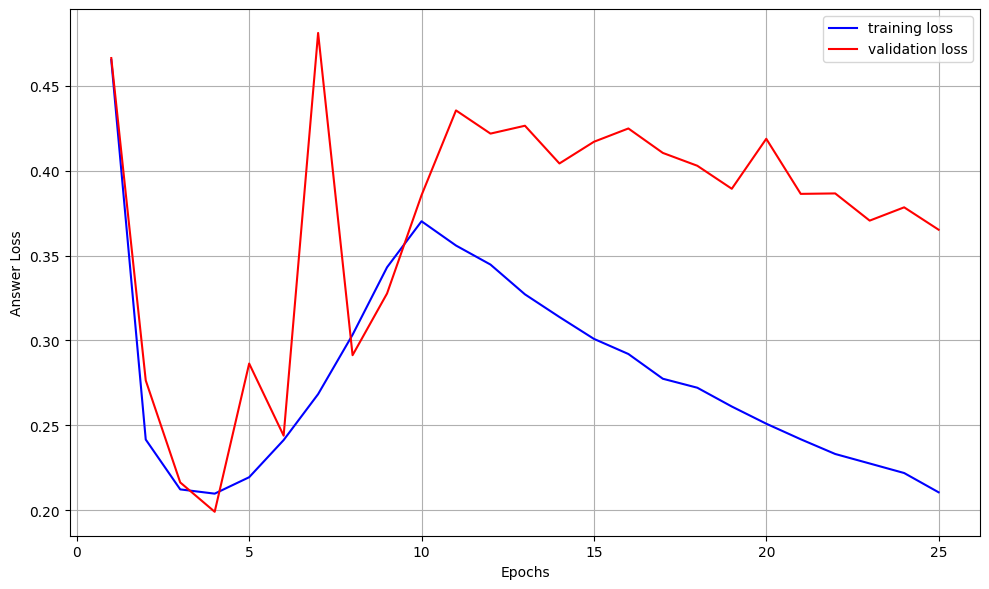

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history['train_loss'])+1), history['train_loss'], c='b', label='training loss')
plt.plot(range(1, len(history['val_loss'])+1), history['val_loss'], c='r', label='validation loss')
#plt.title('Training and Validation VQA Answer Losses over Epochs')
plt.ylabel('Answer Loss')
plt.xlabel('Epochs')
plt.grid('on')
plt.tight_layout()
plt.legend()
plt.savefig(save_dir('total_loss_plot.eps'), format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


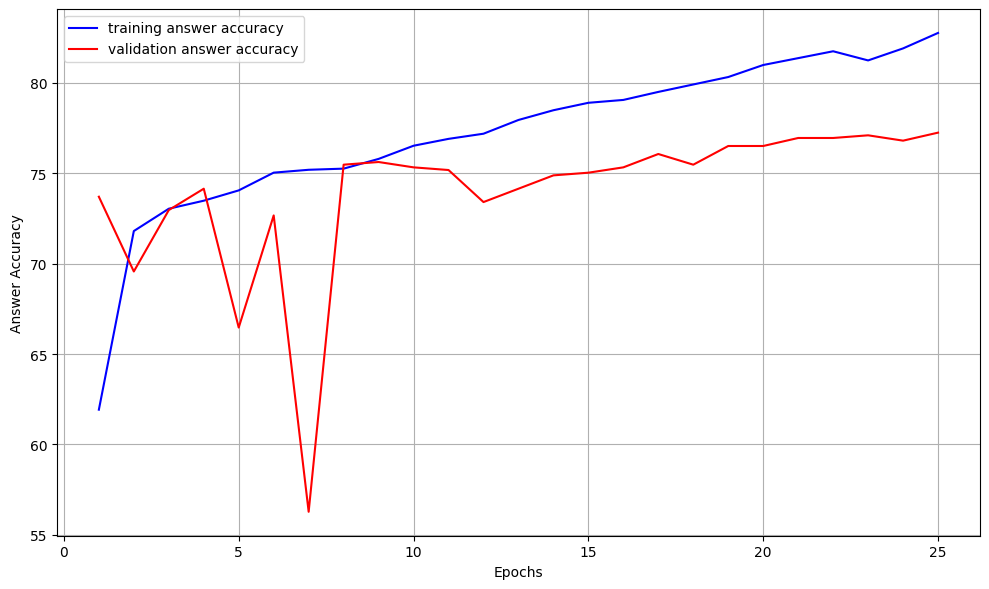

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history['train_answer_acc'])+1), history['train_answer_acc'], c='b', label='training answer accuracy')
plt.plot(range(1, len(history['val_answer_acc'])+1), history['val_answer_acc'], c='r', label='validation answer accuracy')
#plt.title('Training and Validation VQA Answer Accuracies over Epochs')
plt.ylabel('Answer Accuracy')
plt.xlabel('Epochs')
plt.grid('on')
plt.tight_layout()
plt.legend()
plt.savefig(save_dir('vqa_acc_plot.eps'), format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


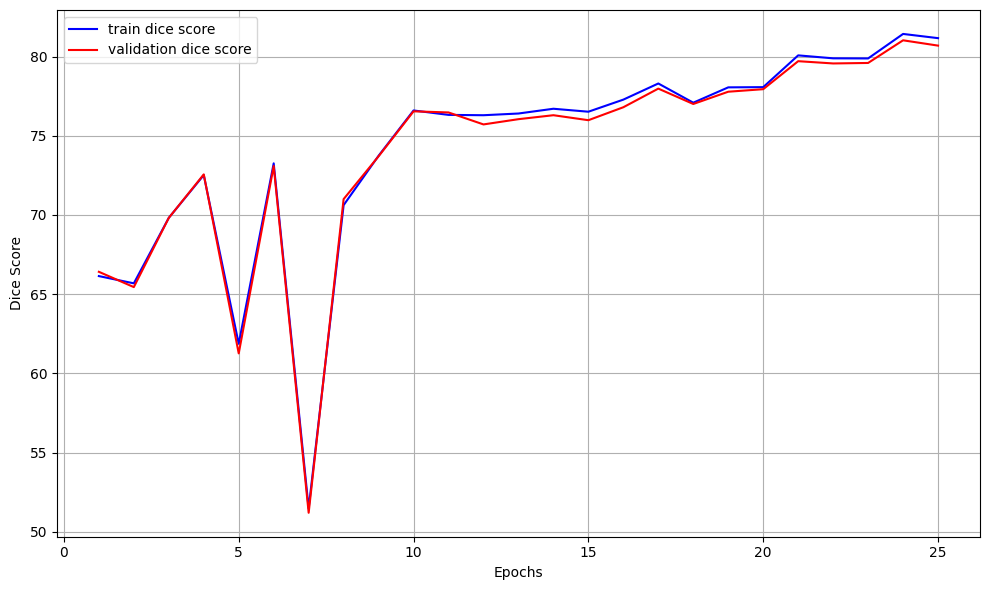

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history['train_dice_score'])+1), history['train_dice_score'], c='b', label='train dice score')
plt.plot(range(1, len(history['val_dice_score'])+1), history['val_dice_score'], c='r', label='validation dice score')
#plt.title('Training and Validation Dice Scores over Epochs')
plt.ylabel('Dice Score')
plt.xlabel('Epochs')
plt.grid('on')
plt.tight_layout()
plt.legend()
plt.savefig(save_dir('dice_score_plot.eps'), format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


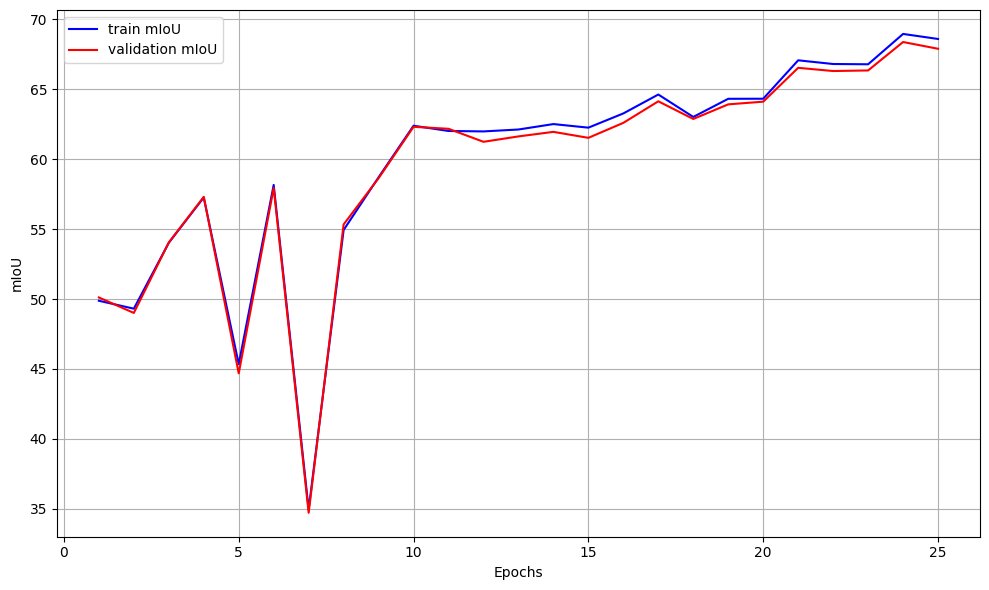

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history['train_miou'])+1), history['train_miou'], c='b', label='train mIoU')
plt.plot(range(1, len(history['val_miou'])+1), history['val_miou'], c='r', label='validation mIoU')
#plt.title('Training and Validation mIoU over Epochs')
plt.ylabel('mIoU')
plt.xlabel('Epochs')
plt.grid('on')
plt.tight_layout()
plt.legend()
plt.savefig(save_dir('mIoU_plot.eps'), format='eps')

# Plot of Alpha History

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


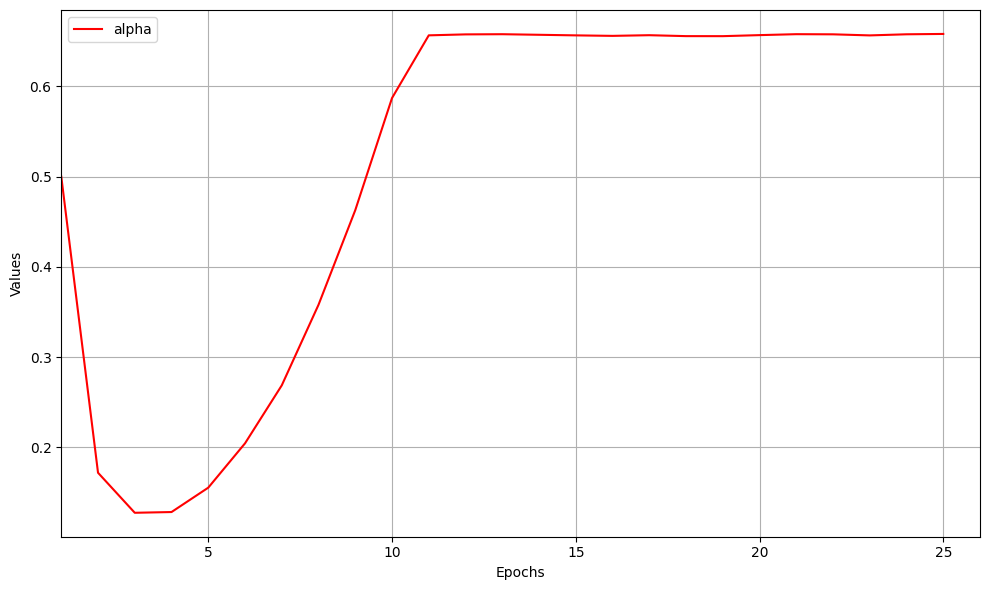

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history['alpha'])+1), history['alpha'], c='r', label='alpha')
#plt.title('Alpha values over Epochs')
plt.ylabel('Values')
plt.xlabel('Epochs')
plt.xlim(1, len(history['alpha'])+1)
plt.grid('on')
plt.tight_layout()
plt.legend()
plt.savefig(save_dir('alpha.eps'), format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


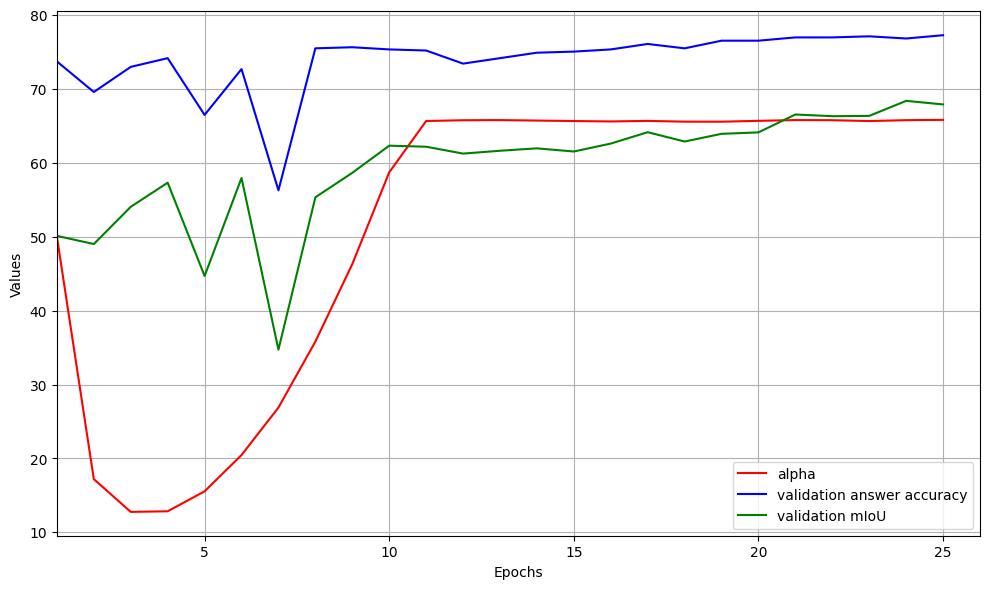

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history['alpha'])+1), [h*100 for h in history['alpha']], c='r', label='alpha')
plt.plot(range(1, len(history['val_answer_acc'])+1), history['val_answer_acc'], c='b', label='validation answer accuracy')
plt.plot(range(1, len(history['val_miou'])+1), history['val_miou'], c='g', label='validation mIoU')
#plt.title('Validation metrics for both VQA and segmentation with alpha values over Epochs\n(Alpha values multiplied by 100)')
plt.ylabel('Values')
plt.xlabel('Epochs')
plt.xlim(1, len(history['alpha'])+1)
plt.grid('on')
plt.tight_layout()
plt.legend()
plt.savefig(save_dir('alpha_with_metrics.eps'), format='eps')

### Save history as JSON file

In [69]:
with open(os.path.join(hyperparameters['RESULTS_AND_HISTORY_FOLDER'], 'history_dict.json'), 'w') as f:
    json.dump(history, f, indent=4)

In [70]:
# BEFORE TESTING, IMPLEMENT LEARNING ALGORITHM
# PASSED, IMPLEMENTED DYNAMIC WEIGHTS (GRADIENTS WRT INPUT IS SAVED FOR LATER)